# **Simple RNN**




In this Notebook, we're going to train a simple RNN to ** time-series prediction **. Given some set of input data, it should be able to generate a prediction for the next time step!







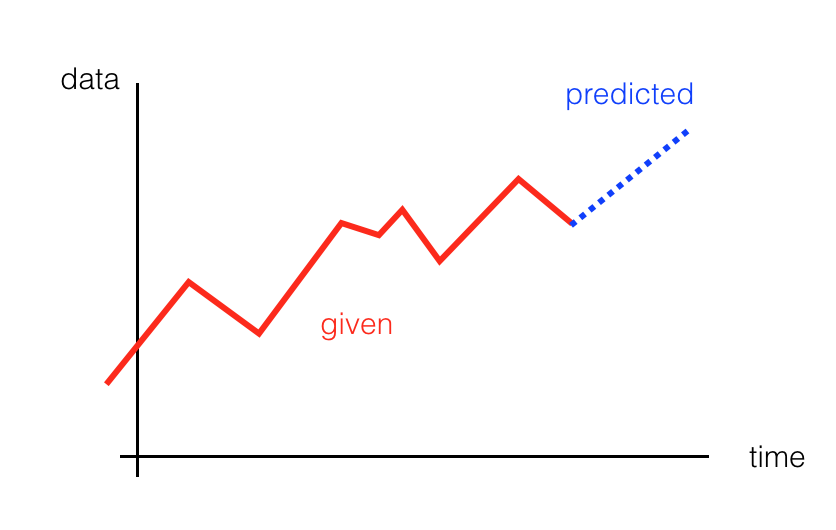



*  First, we'll create our data
*  Then, define an RNN in PyTorch
*  Finally, we'train our network and see how it performs




**Importing necessary libraries and Create data**

In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

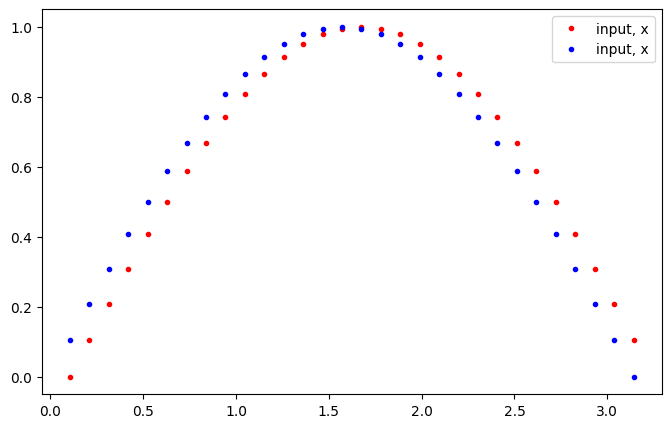

In [9]:
plt.figure(figsize=(8,5))

# How many time steps/data pts are in one batch of data
seq_length = 30

# Generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1 )
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # Size becomes (seq_length + 1 , 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# Display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # X
plt.plot(time_steps[1:], y, 'b.', label='input, x') # Y

plt.legend(loc='best')
plt.show()

**Define the RNN**
Next, we defien an RNN in PyTorch. We'll use nn.RNN to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters.

* input_size - the size of the input
* hidden_dim - the number of features in the RNN output ands in the hidden state
* n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at RNN documentation https://pytorch.org/docs/stable/nn.html#rnn
to read more about recurrent layers.

In [13]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        # Define an RNN with specified parameters
        # Batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # Last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)

        # Get RNN outputs and hidden state
        r_out, hidden = self.rnn(x, hidden)

        # Shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.contiguous().view(-1, self.hidden_dim)

        # Get final output
        output = self.fc(r_out)

        return output, hidden


**Check the Input and Output dimensions**

As a check that your model is working as expected, test out how it responds to input data.

In [16]:
# Test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=20, n_layers=5)

# Generate evenly spaced, test data pts

time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # Give it a batch_size of a as first dimension
print('Input size: ', test_input.size())

# Test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 30, 1])
Output size:  torch.Size([30, 1])
Hidden state size:  torch.Size([5, 1, 20])


Explanation of above output:








([1, 30, 1]) :
1-> batch_size ,
30 -> seq_length,
1 -> input_features










([30, 1]) :
30 -> seq_length,
1 -> output_size









([5, 1, 20]) :
5 -> n_layers
1 -> batch_size
20 -> hidden_dim




**Training the RNN**


Next, we'll instantiated(represent as ) an RNN with some specified hyperparamters. Then train it over a series of steps, and see how it performs.


In [17]:
# Decide on Hyperparameters
input_size=1
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers )
print(rnn)


RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


**Loss and Optimization**
This is a regression problem: Can we train an RNN to accuartely predict the next data point, given a current data point?

* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typically to use an Adam Optimizer  for recurent models.

In [19]:
# MSE(Mean Squared Error) loss and Adam Optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

**Defining the training function**





This function takes in a rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.






Hiddeen State



pay clos attention to the hidden state, here:

* Before looping over a batch of tarining data, the hidden state is initialized
*  After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the folowing steps

In [23]:
# Train the RNN
def train(rnn, n_steps, print_every):

  # Initialize the hidden state
  hidden = None

  for batch_i, step in enumerate(range(n_steps)):
    # Defining the training data
    time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    data.resize((seq_length + 1, 1))  # input_size = 1


    x = data[:-1]
    y = data[1:]

    # Convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

    # Outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)

    ## Representing Memory ##
    # Make a new variable for hidden and detach the hidden state from its history
    # This way, we don't backpropagate through the entire history

    hidden = hidden.data

    # Calculate the loss
    loss = criterion(prediction, y_tensor)
    # Zero gradients
    optimizer.zero_grad()
    # Perform backprop  and update weights
    loss.backward()
    optimizer.step()


    # Display loss and predictions
    if batch_i%print_every == 0:
      print('Loss: ', loss.item())
      plt.plot(time_steps[1:], x, 'r.') # input
      plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')  # predictions
      plt.show()

  return rnn

Loss:  0.13798978924751282


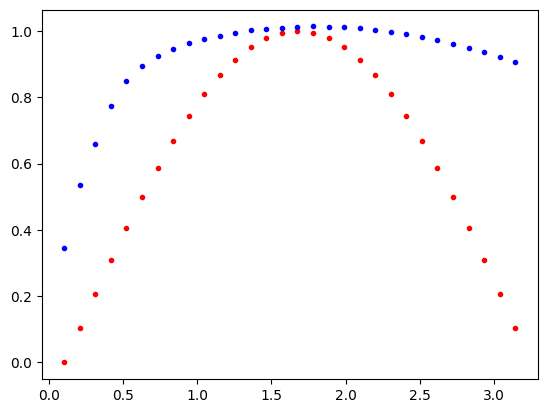

Loss:  0.08652210235595703


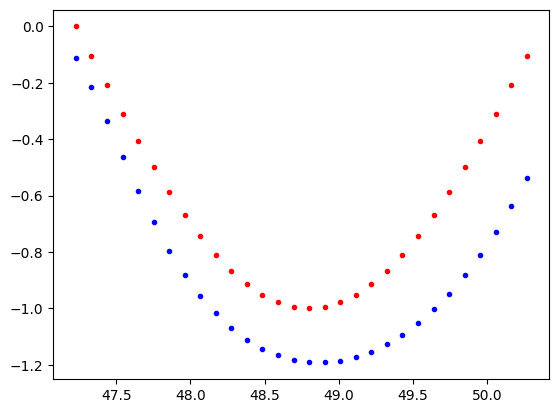

Loss:  0.002413135254755616


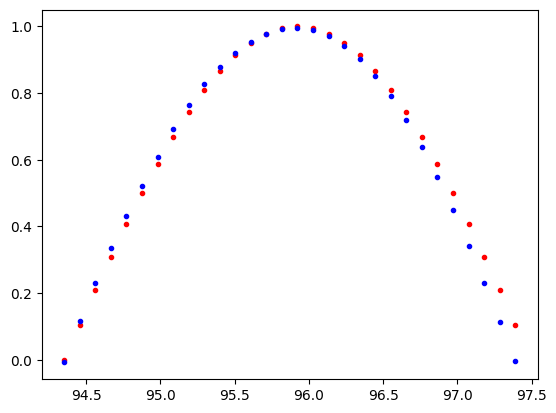

Loss:  0.0009805620647966862


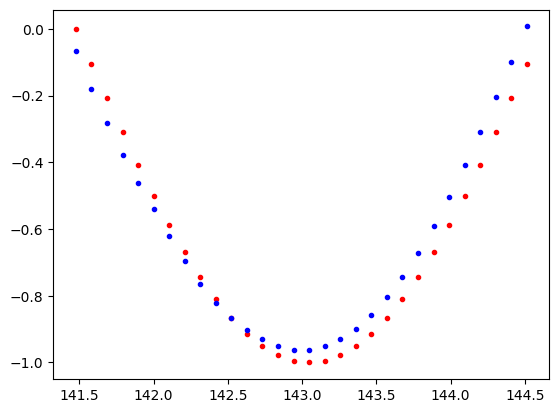

Loss:  0.00021394940267782658


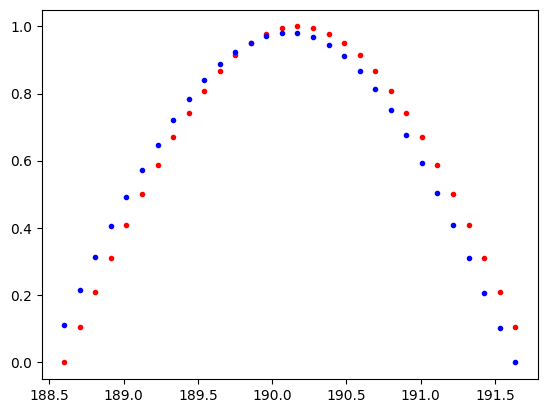

In [24]:
# Train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn= train(rnn, n_steps, print_every)